# Chatbot with message summarization
## Review
We've covered how to customize graph state schema and reducer.

We've also shown a number of ways to trim or filter messages in graph state.

## Goals
Now, let's take it one step further!

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency.

In [1]:
import os, getpass

def _set_env_(var):
    if not os.environ.get(var):
        print("--- API KEY NOT PRESENT ---")
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env_("OPENAI_API_KEY")


In [2]:
_set_env_("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-qwq-32b")

In [4]:
llm.invoke("Hello")

AIMessage(content='\n<think>\nOkay, the user said "Hello". I should respond politely. Let me think of a friendly greeting. Maybe "Hello! How can I assist you today?" That sounds good. It\'s welcoming and offers help. I\'ll go with that.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 11, 'total_tokens': 72, 'completion_time': 0.137794099, 'prompt_time': 0.002740873, 'queue_time': 0.565938686, 'total_time': 0.140534972}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run--a18497a6-e6a1-42fe-af17-74bddbd2776b-0', usage_metadata={'input_tokens': 11, 'output_tokens': 61, 'total_tokens': 72})

In [5]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summery: str

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
import json

def chat_model(state: State) -> json:
    
    summery = state.get("summery")

    if summery:
        system_message = f"Summery of the earlier conversation: {summery}"

        messages = [SystemMessage(content=system_message) + state["messages"]]
    else:
        messages = state["messages"]

    return {"messages": llm.invoke(messages)}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [26]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [27]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

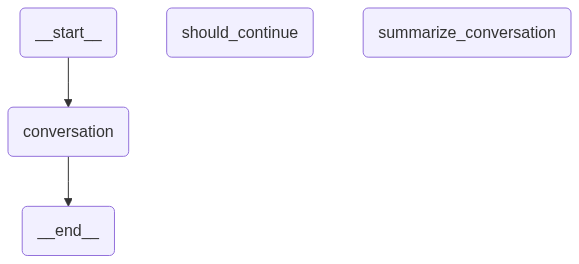

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", chat_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================


<think>
Okay, the user said "hi! I'm Lance." I should respond in a friendly and welcoming way. Let me start by greeting them back. Maybe say "Hello, Lance!" to acknowledge their name. Then, I can offer assistance by asking how I can help them today. Keep it open-ended so they feel comfortable to ask anything. I should make sure the tone is positive and approachable. Let me check if there's anything else I need to include. Nope, that should be good. Alright, time to put it all together in a natural, conversational sentence.
</think>

Hello, Lance! Nice to meet you. How can I assist you today? Feel free to ask me anything! 😊
================================== Ai Message ==================================


<think>
Okay, the user just asked, "what's my name?" Let me think. In the initial message, the user introduced themselves as Lance. So when they first said "hi! I'm Lance," I should remember that.

Wait,